# Tasty Bytes ― Recipe Site Traffic 🍜

**Practical Exam for Data Scientist Professional Certification**

## Company Background 🥗

**Tasty Bytes** is a start-up company founded in 2020 amid the unfolding COVID-19 pandemic. The company's inception was motivated by the global yearning for cooking inspiration.

Initially, Tasty Bytes was conceived as a recipe search engine that assisted individuals in identifying culinary solutions for the limited provisions available at their homes.

After more than two years of business operations, Tasty Bytes has evolved into a fully-fledged enterprise. The company operates on a subscription-based model offering two monthly subscription plans: basic and premium.

The basic subscription plan offers the formulation of a comprehensive culinary regimen encompassing a complete personalized meal plan for both individuals and whole families for a nutritionally balanced diet adaptable to any household budget.

The premium subscription tier upgrades the basic plan with home delivery of the ingredients included in the culinary regimen.

## Product Team Requests 📋

Daily, Tasty Bytes features selected cooking recipes on the its homepage. The company's product team analysis indicates that the most popular recipes generate additional traffic to the rest of the website — up to 40%. Consequently, the increase in web traffic leads to more subscriptions to the Tasty Bytes' services. 

The positive relationship between recipe popularity, web traffic, customer engagement and services subscriptions motivated the company to apply data science and machine learning for its operational and strategic marketing.

The Tasty Bytes' product team has the following requests regarding recipe discovery:
* Predict which recipes will lead to high web traffic.
* Correctly predict high-traffic recipes 80% of the time.

## Dataset 🗄

The product manager of Tasty Bytes provided the `recipe_site_traffic_2212.csv` file containing a sample dataset of the recipe site traffic. 

The following data dictionary explains the dataset in details, and lists the requirements for the data validation.

| Column Name | Data Type | Details |
| --- | --- | --- |
| **`recipe`** | numeric | unique identifier of a recipe |
| **`calories`** | numeric | number of calories |
| **`carbohydrate`** | numeric | amount of carbohydrates in grams |
| **`sugar`** | numeric | amount of sugar in grams |
| **`protein`** | numeric | amount of protein in grams |
| **`category`** | character | recipe type, one of ten possible groupings: <br/> 1. Lunch/Snacks <br/> 2. Beverages <br/> 3. Potato <br/> 4. Vegetable <br/> 5. Meat <br/> 6. Chicken <br/> 7. Pork <br/> 8. Dessert <br/> 9. Breakfast <br/> 10. One-dish meal |
| **`servings`** | numeric | number of servings for the recipe |
| **`high_traffic`** | character | `'High'` indicates if web traffic to the site was high, when the recipe was shown. |

In [1]:
# Import the necessary Python packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import (train_test_split,
                                     KFold, 
                                     cross_val_score,
                                     GridSearchCV)
from sklearn.preprocessing import StandardScaler                             
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, 
                              RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier)
from sklearn import metrics
from yellowbrick.model_selection import FeatureImportances

import warnings

# Suppress all FutureWarnings.
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Read in the dataset into a DataFrame: orig_df.
orig_df = pd.read_csv('datasets/recipe_site_traffic_2212.csv')
orig_df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [3]:
# Print a concise summary of the DataFrame.
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [4]:
# Generate descriptive statistics of all columns in the DataFrame.
orig_df.describe(include='all')

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
count,947.000000,895.000000,895.000000,895.000000,895.000000,947,947,574
unique,NaN,NaN,NaN,NaN,NaN,11,6,1
top,NaN,NaN,NaN,NaN,NaN,Breakfast,4,High
freq,NaN,NaN,NaN,NaN,NaN,106,389,574
mean,474.000000,435.939196,35.069676,9.046547,24.149296,NaN,NaN,NaN
std,273.519652,453.020997,43.949032,14.679176,36.369739,NaN,NaN,NaN
min,1.000000,0.140000,0.030000,0.010000,0.000000,NaN,NaN,NaN
25%,237.500000,110.430000,8.375000,1.690000,3.195000,NaN,NaN,NaN
50%,474.000000,288.550000,21.480000,4.550000,10.800000,NaN,NaN,NaN
75%,710.500000,597.650000,44.965000,9.800000,30.200000,NaN,NaN,NaN


The initial inspection of the dataset reveals the following findings.

The dataset contains 947 rows and eight columns. 

At first glance, there is a substantial amount of missing data in all but three columns (`recipe`, `category`, and `servings`).  Additionally, there are no duplicate values present.

There is also a mismatch of the data type of the `servings` column.

I intend to preserve the original dataset in a DataFrame labeled `orig_df`, while creating a working copy named `tb_df` for the purpose of my data analysis.

In [5]:
# Create a working copy of the original DataFrame: tb_df.
tb_df = orig_df
tb_df.shape

(947, 8)

In [6]:
# Check for duplicated values.
print(tb_df.duplicated().sum())

0


In [7]:
# Check for missing values.
missing_values = tb_df.isna().sum().to_frame(name='missing_count')

# Summarize missing data per column as a number and in percentages.
missing_values['missing_%'] = round(tb_df.isna().mean()*100, 2)
missing_values

,missing_count,missing_%
recipe,0,0.00
calories,52,5.49
carbohydrate,52,5.49
sugar,52,5.49
protein,52,5.49
category,0,0.00
servings,0,0.00
high_traffic,373,39.39


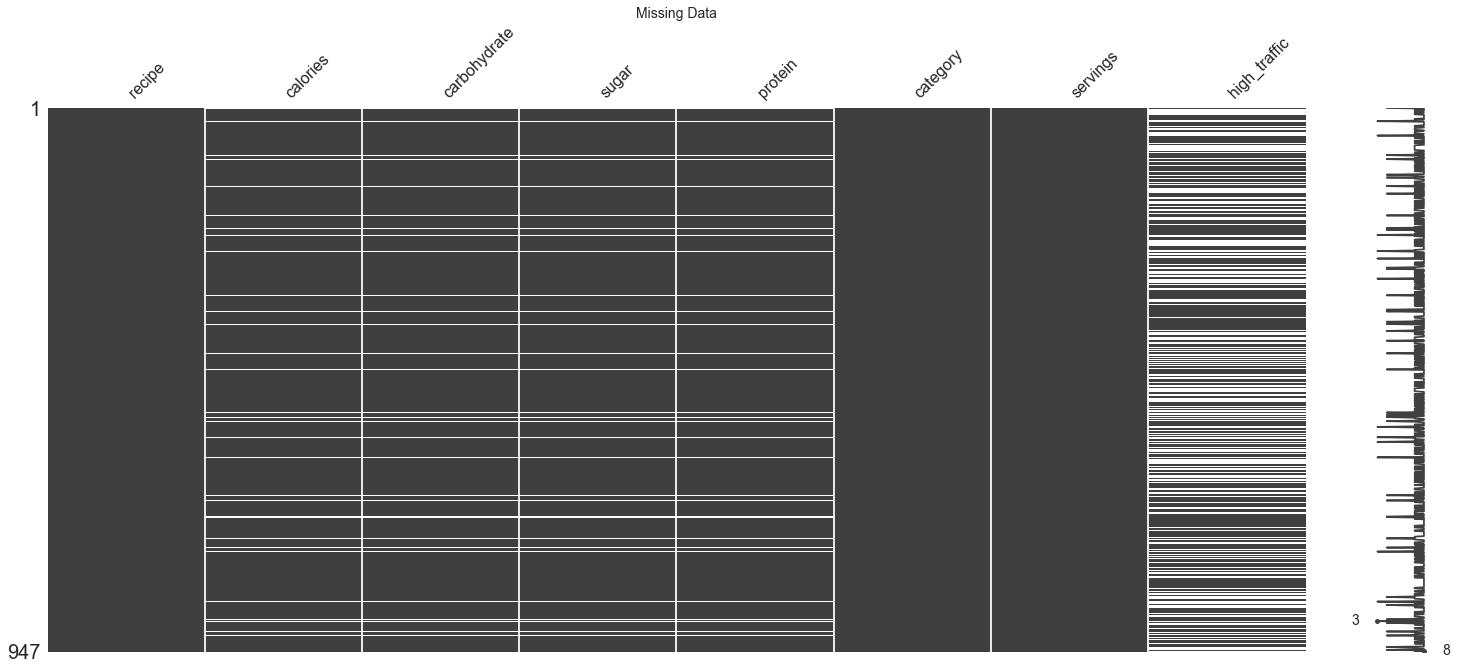

In [8]:
# Visualize missing values in a matrix.
msno.matrix(tb_df)
plt.title("Missing Data",
          fontsize=14)
plt.show()

## Data Validation 🔎 

### `recipe` Column

The `recipe` column has:
* a numeric data type `int`,
* no missing values,
* a range from 1 through 947, i.e. subsequent recipe numbers.

The `recipe` column complies with the data dictionary requirements. As this column contains only a unique ID number for each recipe and holds no additional information that could provide a valuable signal for the machine learning (ML) model that I will train subsequently, I will set this column as an index for the `tb_df` DataFrame.

In [9]:
# Inspect the recipe column.
print(tb_df['recipe'].describe(),'\n')
print(f"The 'recipe' column is of data type {tb_df['recipe'].dtype}.") 

count    947.000000
mean     474.000000
std      273.519652
min        1.000000
25%      237.500000
50%      474.000000
75%      710.500000
max      947.000000
Name: recipe, dtype: float64 

The 'recipe' column is of data type int64.


In [10]:
# Set the recipe column as an index for the tb_df DataFrame.
tb_df.set_index('recipe',
                inplace=True)
tb_df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


### `high_traffic` Column

The next step in my data validation process will be the `high_traffic` column. As this data science project evolves around recipe popularity and high web traffic, the information in this column is essential.

The `high_traffic` column:
* has a character data type `object`,
* contains one unique category `'High'` indicating that this recipe generated high web traffic,
* has 373 missing values, i.e. $\approx39.39\%$.

As there is no additional information as of why the rest of the data points were not annotated with any other label or category, I will make the assumption that the product team of Tasty Bytes had a practice to label **_only_** the popular recipes  with `'High'`to indicate that these generated high web traffic. 

The unmarked recipes with `NaN` in the `high_traffic` column would be assumed as unpopular recipes that did not lead to an increase in customer engagement and had low web traffic; therefore, I will replace their missing values with the label `'Low'`.

After data validation and modification, the `high_traffic` column complies with the data dictionary requirements and has no missing values.

In [11]:
# Inspect the high_traffic_column.
print(f"'high_traffic' data type: '{tb_df['high_traffic'].dtype}'.", '\n')
print(f"'high_traffic' missing values: {tb_df['high_traffic'].isna().sum()}")

'high_traffic' data type: 'object'. 

'high_traffic' missing values: 373


In [12]:
# Replace missing values with `Low` label for low web traffic.
tb_df['high_traffic'].fillna("Low", inplace=True)
print(tb_df['high_traffic'].describe(), '\n')
print(tb_df['high_traffic'].value_counts())

count      947
unique       2
top       High
freq       574
Name: high_traffic, dtype: object 

high_traffic
High    574
Low     373
Name: count, dtype: int64


### `calories` Column

The `calories` column has:
* a numeric data type `float`,
* 52 missing values, i.e. $\approx 5.49\%$.

As a rule of thumb, if the proportion of missing values is above 5%, these values are imputed with a summary statistic based on an educated guess and on the context.

The following columns, `calories`, `carbohydrate`, `sugar`, and `protein` all have missing values above the acceptable threshold of 5%. They also have right-skewed frequency distributions with multiple outliers, as displayed on the histograms later in my data analysis. Therefore, for the data imputation of the missing values in these columns I opted to use the median value per `category` as the median is a better measure of center for skewed distributions with multiple outliers and high variance. 

After data validation and data imputation, the `calories` column has no missing values and complies with the requirements of the data dictionary.

In [13]:
# Inspect the calories column.
print(tb_df['calories'].describe(), '\n')
print(f"The 'calories' column is of data type {tb_df['calories'].dtype}.")

count     895.000000
mean      435.939196
std       453.020997
min         0.140000
25%       110.430000
50%       288.550000
75%       597.650000
max      3633.160000
Name: calories, dtype: float64 

The 'calories' column is of data type float64.


In [14]:
# Create a dictionary with calories median values per category.
calories_dict = tb_df.groupby('category')['calories'].median().to_dict()
calories_dict

{'Beverages': 126.455,
 'Breakfast': 229.38,
 'Chicken': 379.87,
 'Chicken Breast': 371.33500000000004,
 'Dessert': 288.55,
 'Lunch/Snacks': 369.505,
 'Meat': 460.87,
 'One Dish Meal': 419.28,
 'Pork': 399.26,
 'Potato': 269.46,
 'Vegetable': 124.30499999999999}

In [15]:
# Impute the missing data with the calories_dict.
tb_df['calories'] = tb_df['calories'].fillna(tb_df['category'].map(calories_dict))
print(tb_df['calories'].describe())

count     947.000000
mean      431.056241
std       441.370267
min         0.140000
25%       114.410000
50%       296.920000
75%       576.225000
max      3633.160000
Name: calories, dtype: float64


### `carbohydrate` Column

The `cabrohydrate` column has:
* a numeric data type `float`,
* 52 missing values, i.e. $\approx 5.49\%$.

After data validation and data imputation, the `carbohydrate` column has no missing values and complies with the requirements of the data dictionary.

In [16]:
# Inspect the carbohydrate column.
print(tb_df['carbohydrate'].describe(), '\n')
print(f"The 'carbohydrate' column is of data type {tb_df['carbohydrate'].dtype}.")

count    895.000000
mean      35.069676
std       43.949032
min        0.030000
25%        8.375000
50%       21.480000
75%       44.965000
max      530.420000
Name: carbohydrate, dtype: float64 

The 'carbohydrate' column is of data type float64.


In [17]:
# Create a dictionary with carbohydrate median values per category.
carbohydrate_dict = tb_df.groupby('category')['carbohydrate'].median().to_dict()
carbohydrate_dict

{'Beverages': 11.25,
 'Breakfast': 28.42,
 'Chicken': 18.11,
 'Chicken Breast': 13.475000000000001,
 'Dessert': 38.55,
 'Lunch/Snacks': 31.985,
 'Meat': 19.115000000000002,
 'One Dish Meal': 25.43,
 'Pork': 19.56,
 'Potato': 32.54,
 'Vegetable': 13.335}

In [18]:
# Impute the missing data with the carbohydrate_dict.
tb_df['carbohydrate'] = tb_df['carbohydrate'].fillna(tb_df['category'].map(carbohydrate_dict))
print(tb_df['carbohydrate'].describe())

count    947.000000
mean      34.454947
std       42.844746
min        0.030000
25%        9.135000
50%       21.190000
75%       42.590000
max      530.420000
Name: carbohydrate, dtype: float64


### `sugar` Column

The `sugar` column has:
* a numeric data type `float`,
* 52 missing values, i.e. $\approx 5.49\%$.

After data validation and data imputation, the `sugar` column has no missing values and complies with the requirements of the data dictionary.

In [19]:
# Inspect the sugar column.
print(tb_df['sugar'].describe(), '\n')
print(f"The 'sugar' column is of data type {tb_df['sugar'].dtype}.")

count    895.000000
mean       9.046547
std       14.679176
min        0.010000
25%        1.690000
50%        4.550000
75%        9.800000
max      148.750000
Name: sugar, dtype: float64 

The 'sugar' column is of data type float64.


In [20]:
# Create a dictionary with sugar median values per category.
sugar_dict = tb_df.groupby('category')['sugar'].median().to_dict()
sugar_dict

{'Beverages': 8.075,
 'Breakfast': 4.83,
 'Chicken': 3.17,
 'Chicken Breast': 3.645,
 'Dessert': 24.65,
 'Lunch/Snacks': 2.75,
 'Meat': 3.385,
 'One Dish Meal': 4.04,
 'Pork': 5.23,
 'Potato': 2.64,
 'Vegetable': 3.7}

In [21]:
# Impute the missing data with the sugar_dict.
tb_df['sugar'] = tb_df['sugar'].fillna(tb_df['category'].map(sugar_dict))
print(tb_df['sugar'].describe())

count    947.000000
mean       8.887598
std       14.372359
min        0.010000
25%        1.795000
50%        4.400000
75%        9.565000
max      148.750000
Name: sugar, dtype: float64


### `protein` Column

The `protein` column has:
* a numeric data type `float`,
* 52 missing values, i.e. $\approx 5.49\%$.

After data validation and data imputation, the `protein` column has no missing values and complies with the requirements of the data dictionary.

In [22]:
# Inspect the protein column.
print(tb_df['protein'].describe(), '\n')
print(f"The 'protein' column is of data type {tb_df['protein'].dtype}.")

count    895.000000
mean      24.149296
std       36.369739
min        0.000000
25%        3.195000
50%       10.800000
75%       30.200000
max      363.360000
Name: protein, dtype: float64 

The 'protein' column is of data type float64.


In [23]:
# Create a dictionary with protein median values per category.
protein_dict = tb_df.groupby('category')['protein'].median().to_dict()
protein_dict

{'Beverages': 0.41000000000000003,
 'Breakfast': 11.685,
 'Chicken': 32.98,
 'Chicken Breast': 37.769999999999996,
 'Dessert': 4.81,
 'Lunch/Snacks': 12.965,
 'Meat': 28.53,
 'One Dish Meal': 28.48,
 'Pork': 29.82,
 'Potato': 5.9,
 'Vegetable': 4.835}

In [24]:
# Impute the missing data with the protein_dict.
tb_df['protein'] = tb_df['protein'].fillna(tb_df['category'].map(protein_dict))
print(tb_df['protein'].describe())

count    947.000000
mean      23.957212
std       35.479461
min        0.000000
25%        3.465000
50%       11.240000
75%       29.820000
max      363.360000
Name: protein, dtype: float64


### `category` Column

The `category` column has:
* a character data type `object`,
* no missing values,
* 11 unique categories, but 10 are required by the data dictionary.

The redundant category is `'Chicken Breast'` which will be assigned to the `'Chicken'` category, and after data modification, this column has 10 unique categories.

The `category` column will be converted to a `pandas'` `category` data type, which will remain a string variable that complies with the data dictionary.

In [25]:
# Inspect the category column.
print(tb_df['category'].describe(), '\n')
tb_df['category'].unique()

count           947
unique           11
top       Breakfast
freq            106
Name: category, dtype: object 



array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

In [26]:
# Assign the 'Chicken Breast' category to 'Chicken'.
tb_df[tb_df['category'] == 'Chicken Breast']['category'].count()
tb_df['category'] = tb_df['category'].str.replace('Chicken Breast', 'Chicken')

# Convert category column to pandas category data type.
tb_df['category'] = tb_df['category'].astype('category')

# Check the category column after data modification.
print(tb_df['category'].describe(), '\n')
tb_df['category'].dtype

count         947
unique         10
top       Chicken
freq          172
Name: category, dtype: object 



CategoricalDtype(categories=['Beverages', 'Breakfast', 'Chicken', 'Dessert',
                  'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato',
                  'Vegetable'],
, ordered=False, categories_dtype=object)

### `servings` Column

The `servings` column has:
* a character data type `object`, and it needs to be of numeric data type according to the data dictionary,
* has no missing values.

The `servings` column contains character strings with some inconsistencies in the data. Some servings are entered as numbers, some as strings, e.g. `4 as a snack` and `6 as a snack`. 

The `as a snack` part of the servings data was removed and only the numeric part was retained. Thereafter, the data type of the `servings` column was changed to `int` to comply with the data dictionary.

In [27]:
# Inspect the servings column.
display(tb_df['servings'].describe())
print(f"The 'servings' column is of data type {tb_df['servings'].dtype}.")
tb_df['servings'].unique()

count     947
unique      6
top         4
freq      389
Name: servings, dtype: object

The 'servings' column is of data type object.


array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

In [28]:
# Remove the `as a snack` part from the servings column.
tb_df['servings'] = tb_df['servings'].str.rstrip(' as a snack')

# Change the data type of the servings column to integer.
tb_df['servings'] = tb_df['servings'].astype('int')

# Check the servings columns after data modification.
display(tb_df['servings'].describe())
print(f"The 'servings' column is of data type {tb_df['servings'].dtype}.")

count    947.000000
mean       3.477297
std        1.732741
min        1.000000
25%        2.000000
50%        4.000000
75%        4.000000
max        6.000000
Name: servings, dtype: float64

The 'servings' column is of data type int64.


In [29]:
# Dataset structure after data validation and cleaning.
print(tb_df.dtypes, '\n')
tb_df.describe(include='all')

calories         float64
carbohydrate     float64
sugar            float64
protein          float64
category        category
servings           int64
high_traffic      object
dtype: object 



,calories,carbohydrate,sugar,protein,category,servings,high_traffic
count,947.000000,947.000000,947.000000,947.000000,947,947.000000,947
unique,NaN,NaN,NaN,NaN,10,NaN,2
top,NaN,NaN,NaN,NaN,Chicken,NaN,High
freq,NaN,NaN,NaN,NaN,172,NaN,574
mean,431.056241,34.454947,8.887598,23.957212,NaN,3.477297,NaN
std,441.370267,42.844746,14.372359,35.479461,NaN,1.732741,NaN
min,0.140000,0.030000,0.010000,0.000000,NaN,1.000000,NaN
25%,114.410000,9.135000,1.795000,3.465000,NaN,2.000000,NaN
50%,296.920000,21.190000,4.400000,11.240000,NaN,4.000000,NaN
75%,576.225000,42.590000,9.565000,29.820000,NaN,4.000000,NaN


### Dataset Structure Summary (after data validation, cleaning, and imputation)

| Column Name | Data Type | Count | Missing Values | Unique Values | Range | High Variance |
| --- | --- | :---: | :---: | --- | --- | :---: |
| **`recipe`** | numeric, `int` | 947 | 0 | n/a | 1-947 | n/a |
| **`calories`** | numeric, `float` | 947 | 0 | n/a | 0.14-3633.16 | ❗ |
| **`carbohydrate`** | numeric, `float` | 947 | 0 | n/a | 0.03-530.42 | ❗ | 
| **`sugar`** | numeric, `float` | 947 | 0 | n/a | 0.01-148.75 | ❗ |
| **`protein`** | numeric, `float` | 947 | 0 | n/a | 0-363.36 | ❗ |
| **`category`** | character, `category` | 947 | 0 | 1. Lunch/Snacks <br/> 2. Beverages <br/> 3. Potato <br/> 4. Vegetable <br/> 5. Meat <br/> 6. Chicken <br/> 7. Pork <br/> 8. Dessert <br/> 9. Breakfast <br/> 10. One-dish meal | n/a | n/a |
| **`servings`** | numeric, `int` | 947 | 0 | n/a | 1-6 | n/a |
| **`high_traffic`** | character, `object` | 947 | 0 | 1. High <br/>2. Low | n/a | n/a |

## Exploratory Data Analysis 🧮

After data validation and data modification, the dataset comprises two categorical and five numerical values.

I begin my exploratory data analysis (EDA) with the `high_traffic` column to investigate the frequency distribution of the recipes and their impact on web traffic.

In [30]:
# Calculate the counts of recipes by web traffic.
web_traffic = tb_df['high_traffic'].value_counts().to_frame()
web_traffic['percentage'] = round(tb_df['high_traffic'] \
                                  .value_counts(normalize=True)*100, 2)
web_traffic

,count,percentage
high_traffic,,
High,574,60.61
Low,373,39.39


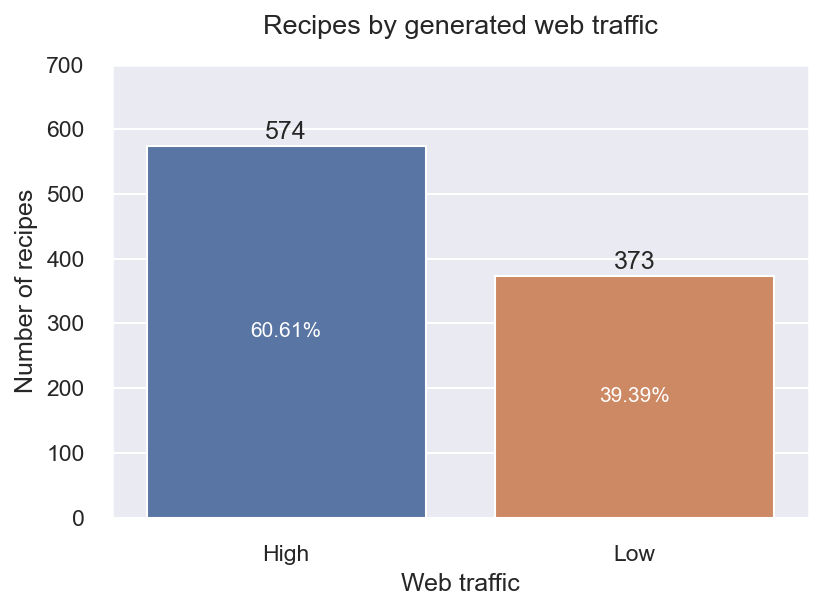

In [31]:
# Visualize the high_traffic column.
sns.set(rc={"figure.dpi":150})
sns.set_style('darkgrid')
ax = sns.barplot(data=web_traffic,
                 x=web_traffic.index,
                 y='count')
for i in ax.containers:
    ax.bar_label(i, padding=1.04)
ax.bar_label(ax.containers[0],
             labels=['60.61%', '39.39%'],
             label_type='center',
             color='white',
             fontsize=10)
plt.title("Recipes by generated web traffic",
          y=1.04,
          fontsize=13)
plt.xlabel("Web traffic")
plt.ylabel("Number of recipes")
plt.yticks(range(0, 750, 100))
plt.show()

As demonstrated by the frequency distribution table presented above and the bar plot depicting the `high_traffic` column, it is evident that 574 popular recipes (or slightly over 60%) led to high web traffic, while 373 recipes can be categorized as less popular resulting in no significant impact on the web traffic volume.

In the subsequent phase, my analysis will extend to the `category` column as I aim to visualize the distribution of recipes across various categories.

,category,count,percentage
0,Chicken,172,18.16
1,Breakfast,106,11.19
2,Beverages,92,9.71
3,Lunch/Snacks,89,9.40
4,Potato,88,9.29
5,Pork,84,8.87
6,Dessert,83,8.76
7,Vegetable,83,8.76
8,Meat,79,8.34
9,One Dish Meal,71,7.50


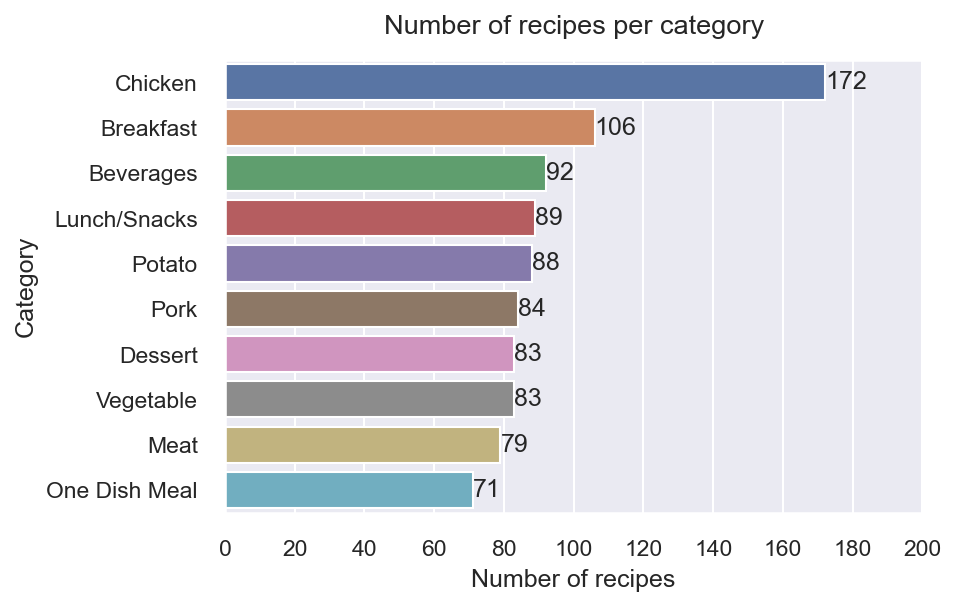

In [32]:
# Explore the recipes distribution by category.
sorted_cat = tb_df['category'].value_counts().reset_index()
sorted_cat['percentage'] = sorted_cat['count'].apply(
    lambda c: round(c / sorted_cat['count'].sum() * 100, 2))
                                
display(sorted_cat)

ax = sns.barplot(data=sorted_cat,
                 x='count',
                 y='category', 
                 order=sorted_cat['category'])

ax.bar_label(ax.containers[0])
plt.title("Number of recipes per category",
          y=1.03,
          fontsize=13)
plt.xlabel("Number of recipes")
plt.ylabel("Category")
plt.xticks(range(0, 220, 20))
plt.show()

The data outlining the distribution of recipes by category has been summarized in the `sorted_cat` DataFrame and is visualized in a horizontal bar plot. In this visualization, the categories are arranged in descending order. Notably, the category `Chicken` stands out as the most prevalent, accounting for over 18% of all featured recipes, while `Beverages` closely follows with a representation of over 11%. The frequencies of the remaining categories fall within the range of 7.5% to 9.71%.

In [33]:
# Extract data for web traffic by category.
cat_traffic = tb_df.groupby(['category', 'high_traffic'],
                            observed=False)['high_traffic'] \
                   .agg(count = 'count')

# Create a pivot table for web traffic by category.
traff_cat = pd.pivot_table(data=cat_traffic,
                           index='category',
                           columns='high_traffic',
                           values='count').sort_values('High', 
                                                       ascending=False)
traff_cat

high_traffic,High,Low
category,,
Potato,83.0,5.0
Vegetable,82.0,1.0
Pork,77.0,7.0
Chicken,73.0,99.0
Meat,59.0,20.0
Lunch/Snacks,57.0,32.0
Dessert,53.0,30.0
One Dish Meal,52.0,19.0
Breakfast,33.0,73.0


To explore the contribution of each category to the web traffic, I combined the data from the `category` and `high_traffic` variables in a pivot table `traff_cat`, which showcases the count of recipes that contribute to both high and low web traffic.

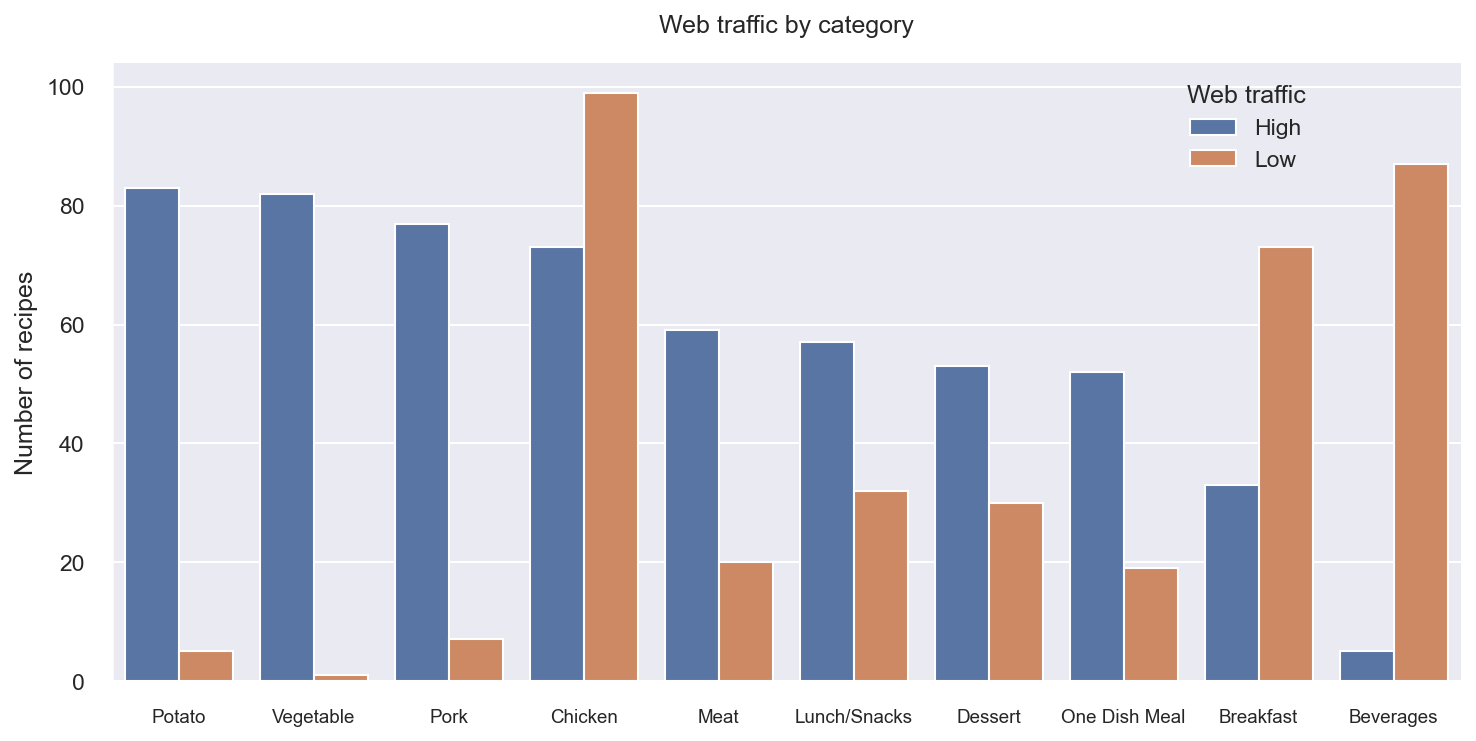

In [34]:
# Plot web traffic by category.
sns.catplot(kind='count',
            data=tb_df,
            x='category',
            hue='high_traffic',
            order=traff_cat.index,
            legend=False,
            aspect=10/5
            )
plt.title("Web traffic by category",
          y=1.03,
          fontsize=12)
plt.xlabel("")
plt.xticks(fontsize=9)
plt.ylabel("Number of recipes")
plt.legend(title="Web traffic",
           loc='best',
           bbox_to_anchor=(0.2, 0.5, 0.7, 0.5))
plt.show()

The above bar plot visualizes the web traffic by category, where the bars are sorted by the `High` web traffic values in descending order. Notably, the categories `Potato`, `Vegetable`, and `Pork`' emerge as the primary contributors to high web traffic. However, the category `Chicken` is ambiguous: it ranks fourth in high traffic contribution while simultaneously being the largest contributor to low web traffic. This suggests a need for a closer examination of `Chicken` recipes to discern the factors that determine their success or failure.

Conversely, the categories that predominantly result in low web traffic are `Chicken`, `Beverages`, and `Breakfast`.

I merged the data pertaining to recipe distribution by category and web traffic by category into a DataFrame `recip_traff` shown below. This table highlights a noteworthy observation: the top three recipe categories most frequently featured on the website — namely, `Chicken`, `Breakfast`, and `Beverages` — comprise the majority of unpopular recipes that generate the lowest web traffic. Consequently, Tasty Bytes should definitely consider a new approach to recipe selection for its homepage.

In [35]:
# Merge the tables sorted_cat and traff_cat.
recip_traff = sorted_cat[['category', 'count']].merge(traff_cat,
                               on='category')
recip_traff.sort_values(by=['count', 'Low', 'High'],
                        ascending=False)

,category,count,High,Low
0,Chicken,172,73.0,99.0
1,Breakfast,106,33.0,73.0
2,Beverages,92,5.0,87.0
3,Lunch/Snacks,89,57.0,32.0
4,Potato,88,83.0,5.0
5,Pork,84,77.0,7.0
6,Dessert,83,53.0,30.0
7,Vegetable,83,82.0,1.0
8,Meat,79,59.0,20.0
9,One Dish Meal,71,52.0,19.0


Moving forward, I proceed with my exploratory data analysis by examining the numerical variables, namely, `calories`, `carbohydrate`, `sugar`, `protein`, and `servings`. The graph presented below showcases the distributions of these variables through individual histograms.

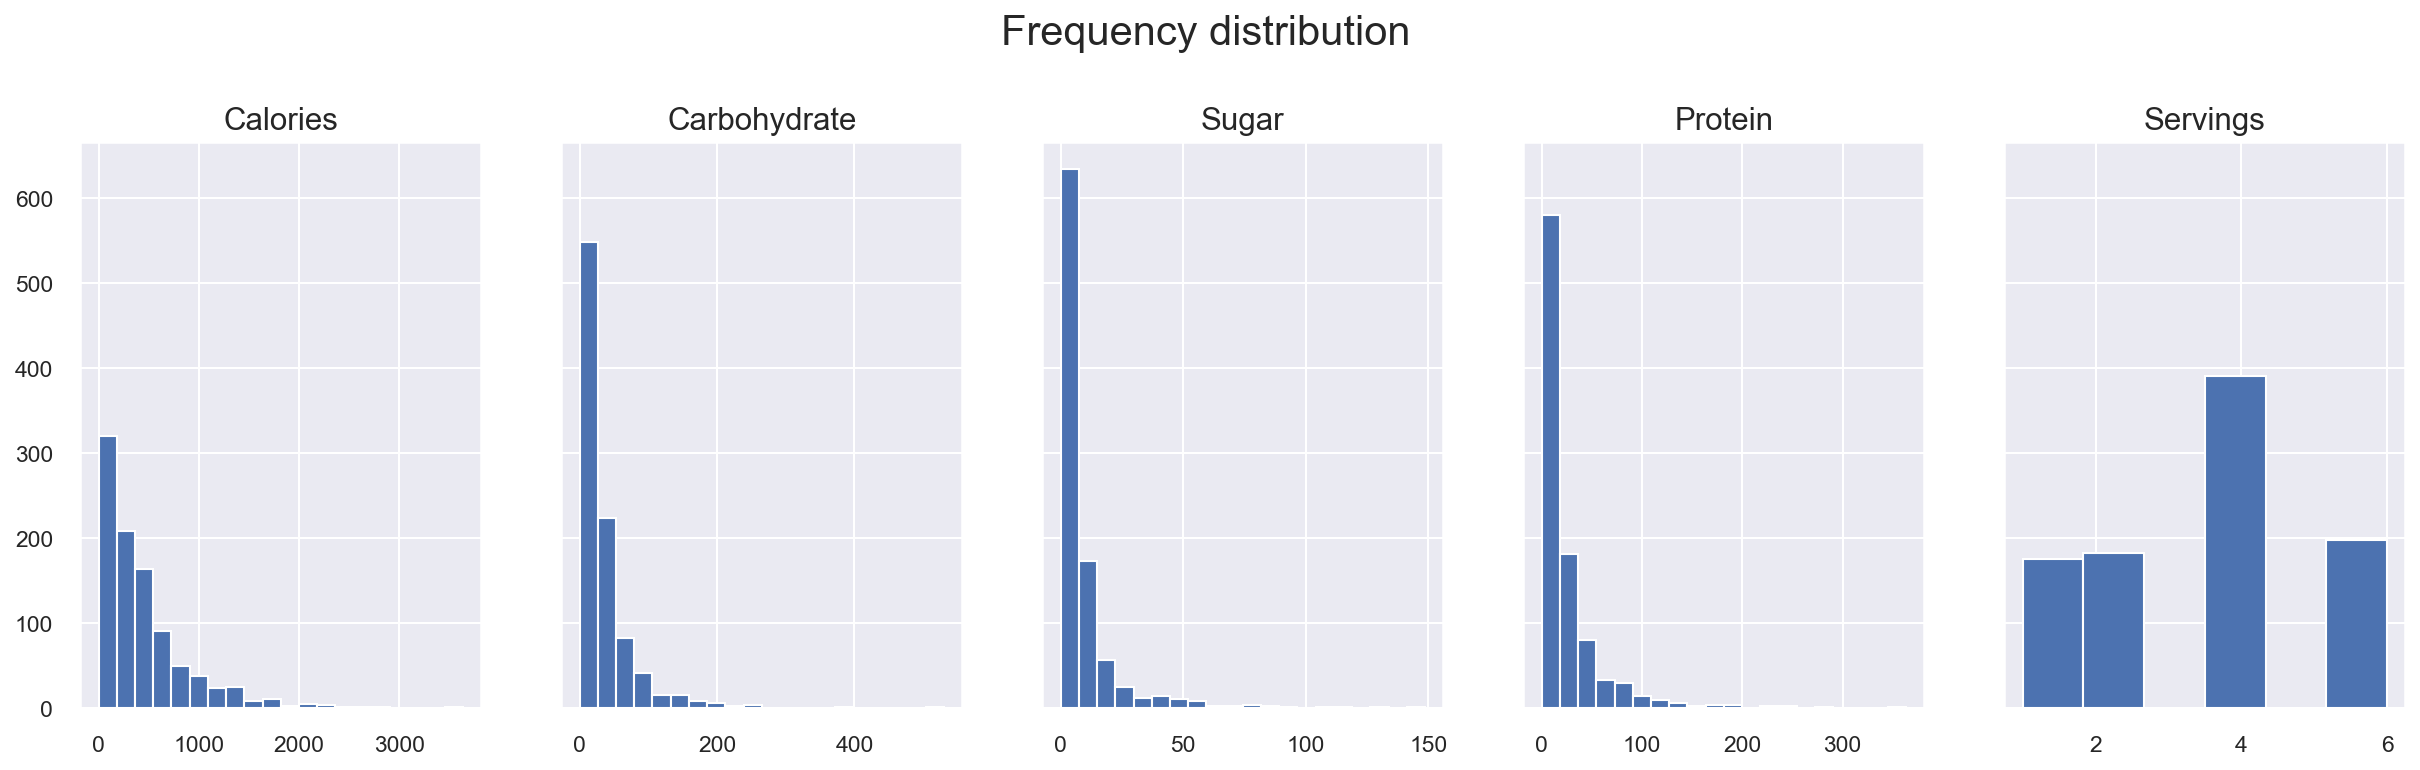

In [36]:
# Create frequency distribution histograms for all numerical variables.
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1,
                                              ncols=5,
                                              sharey=True,
                                              figsize=(20, 5))

fig.suptitle("Frequency distribution",
             fontsize=20,
             y=1.05)

# calories column
ax1.set_title("Calories", fontsize=15)
ax1.hist(tb_df['calories'], bins=20)

# carbohydrate column
ax2.set_title("Carbohydrate", fontsize=15)
ax2.hist(tb_df['carbohydrate'], bins=20)

# sugar column
ax3.set_title("Sugar", fontsize=15)
ax3.hist(tb_df['sugar'], bins=20)

# protein column
ax4.set_title("Protein", fontsize=15)
ax4.hist(tb_df['protein'], bins=20)

# servings column
ax5.set_title("Servings", fontsize=15)
ax5.hist(tb_df['servings'], bins=6)

plt.show()

Out of the numerical variables considered, only the `servings` variable exhibits values that follow a relatively normal distribution. Conversely, the remaining variables display right-skewed distributions, suggesting the presence of numerous outliers. This distribution shape influenced my decision to employ the median as the imputation method for missing values in these columns, as it is a more robust measure of central tendency in non-normally distributed variables.

The numerical variables do not conform to a normal distribution,  exhibit multiple outliers, possess substantial variance, and exist on different 
 scales. These characteristics underscore the necessity for data normalization during the preprocessing phase of developing the machine learning model.

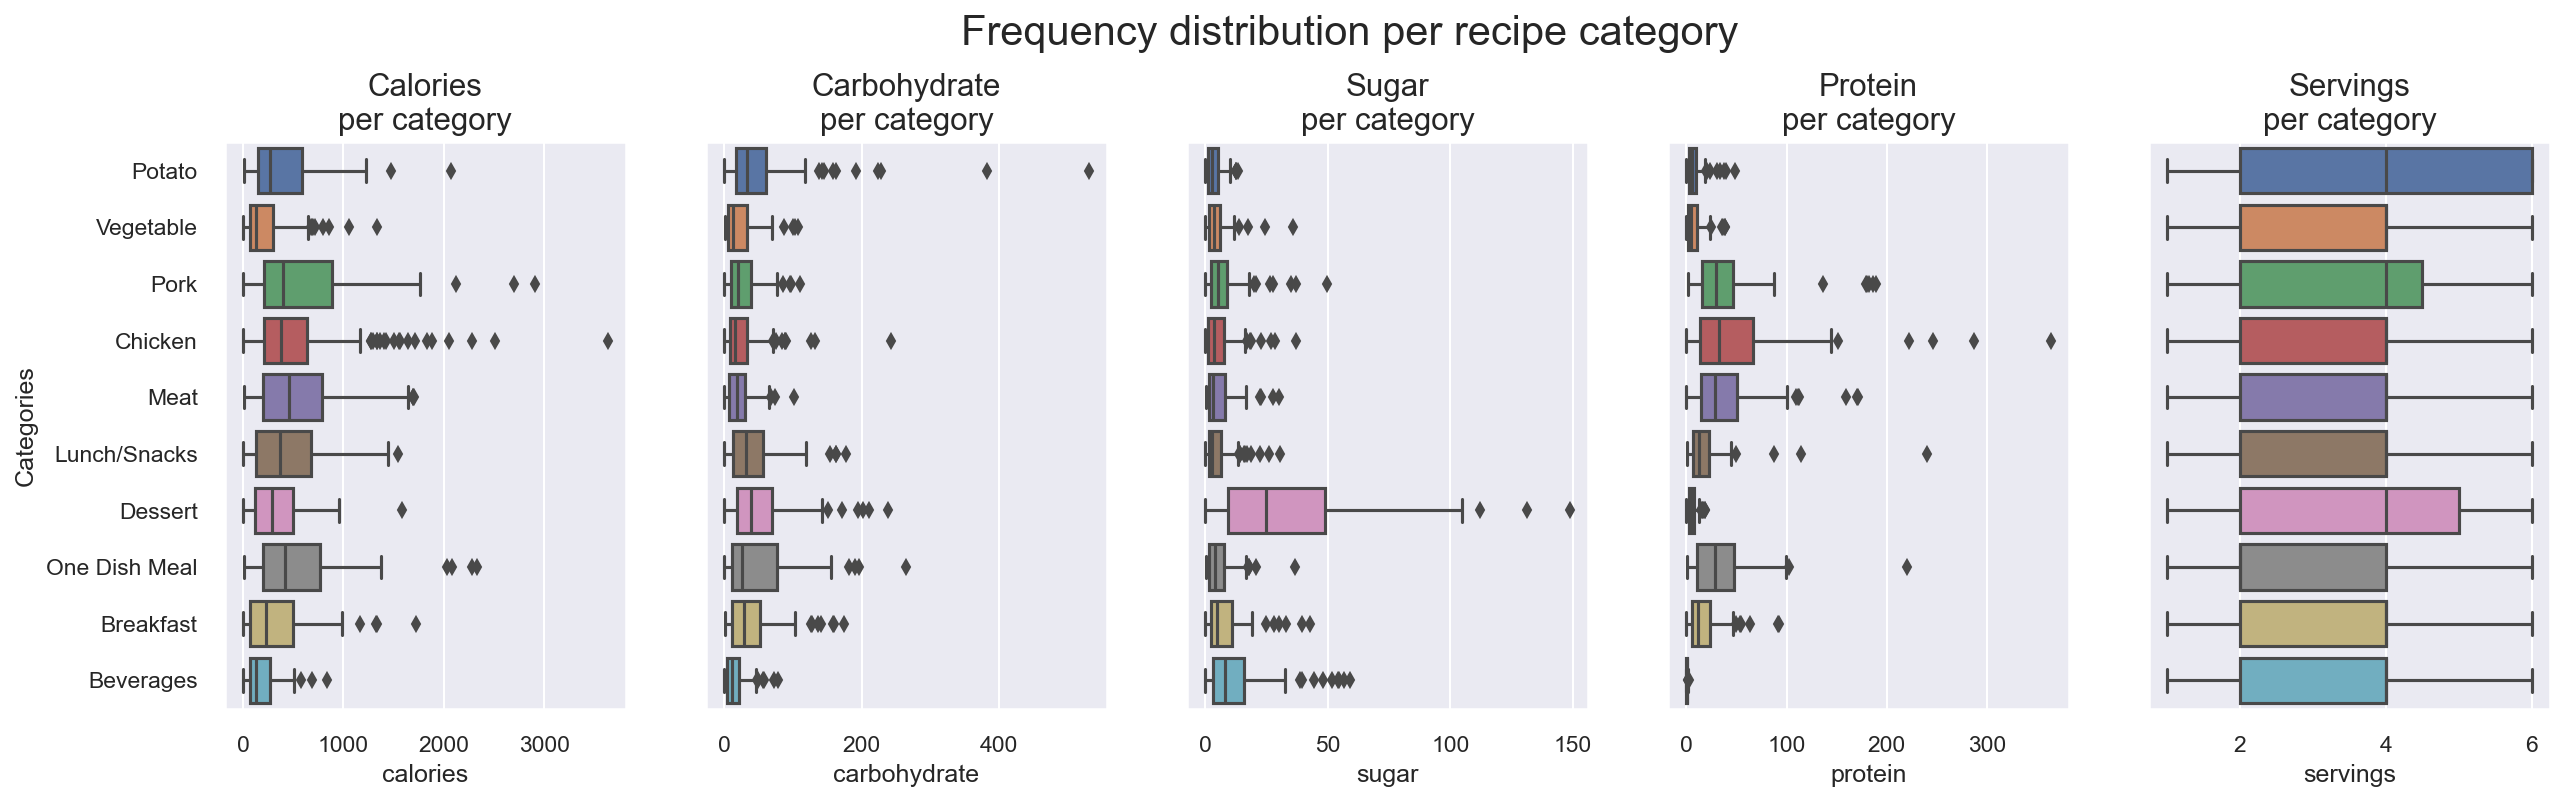

In [37]:
# Plot the numerical variables frequency distribution by category.
fig, ax = plt.subplots(nrows=1,
                       ncols=5,
                       sharey=True,
                       figsize=(20, 5))

fig.suptitle("Frequency distribution per recipe category",
             fontsize=20,
             y=1.05)

# Plot calories frequency by recipe category.
sns.boxplot(data=tb_df,
            x='calories',
            y='category',
            order=traff_cat.index,
            ax=ax[0],
            )
ax[0].set_title('Calories\nper category', fontsize=15)
ax[0].set_ylabel("Categories")

# Plot carbohydrate frequency by recipe category.
sns.boxplot(data=tb_df,
            x='carbohydrate',
            y='category',
            order=traff_cat.index,
            ax=ax[1],
            )
ax[1].set_title('Carbohydrate\nper category', fontsize=15)
ax[1].set(ylabel='')

# Plot sugar frequency by recipe category.
sns.boxplot(data=tb_df,
            x='sugar',
            y='category',
            order=traff_cat.index,
            ax=ax[2],
            )
ax[2].set_title('Sugar\nper category', fontsize=15)
ax[2].set(ylabel='')

# Plot protein frequency by recipe category.
sns.boxplot(data=tb_df,
            x='protein',
            y='category',
            order=traff_cat.index,
            ax=ax[3],
            )
ax[3].set_title('Protein\nper category', fontsize=15)
ax[3].set(ylabel='')

# Plot servings frequency by recipe category.
sns.boxplot(data=tb_df,
            x='servings',
            y='category',
            order=traff_cat.index,
            ax=ax[4],
            )
ax[4].set_title('Servings\nper category', fontsize=15)
ax[4].set(ylabel='')

plt.show()

The plot displayed above illustrates the frequency distributions of the numerical variables within the dataset, visualized by recipe category. The width of the interquartile ranges in the box plots, along with the presence of outliers, offers insights into the extent of value deviations and variance within each numerical column, organized by category.

These box plots are arranged in descending order of recipe popularity, determined by web traffic. It appears that the most popular recipes tend to have lower to average values for calories, carbohydrate, and protein, exceptionally low values for sugar, and larger serving sizes.

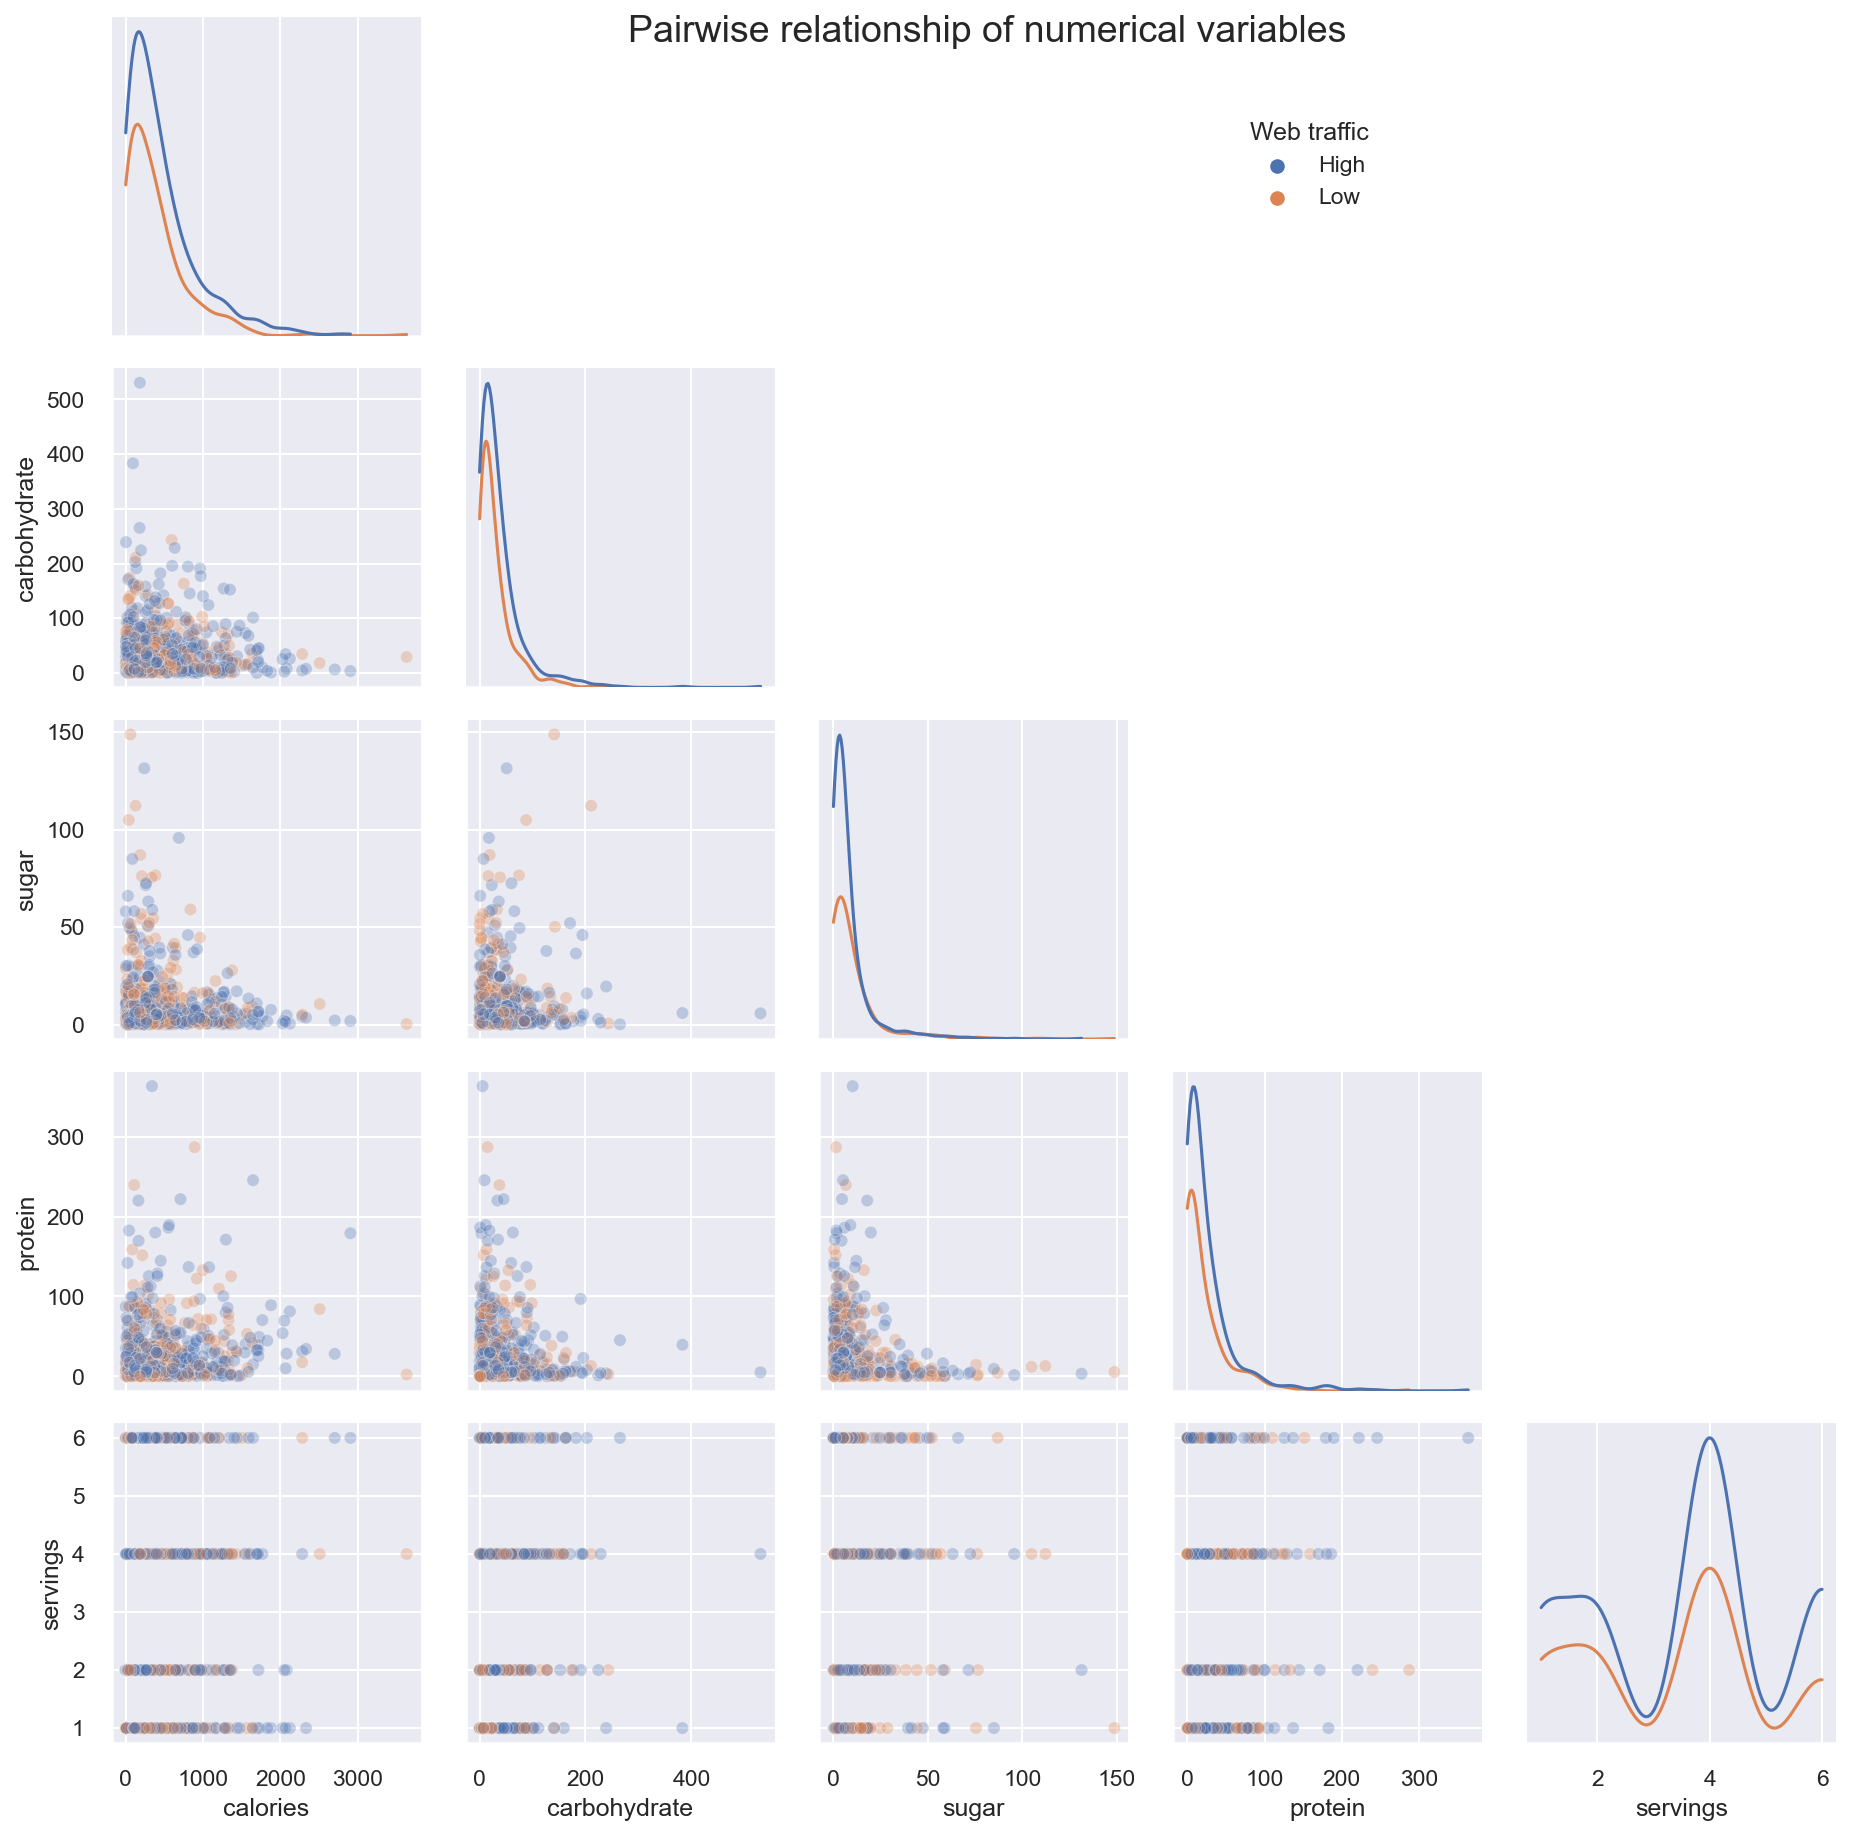

In [38]:
# Create a PairGrid plot of the pairwise relationships of the numeric variables.
g = sns.PairGrid(tb_df, corner=True, 
                 diag_sharey=False, 
                 hue='high_traffic')
g.map_lower(sns.scatterplot, alpha=0.3)
g.map_diag(sns.kdeplot, cut=0)
g.fig.suptitle("Pairwise relationship of numerical variables",
               fontsize=18)
g.add_legend(title="Web traffic",
             bbox_to_anchor=(.0, 0.6, 0.7, 0.6))
plt.show()

This pair plot visualizes the pairwise relationship between the numerical variables in the dataset segregated by web traffic as a third variable. 

Along the diagonal of the pair plot, there's a univariate kernel density estimate (KDE) function that presents the distribution of the individual numerical values in two dimensions for both high and low web traffic. Interestingly, these distributions appear to run parallel to each other.

The scatter plots depict the associations between pairs of numerical variables, with web traffic serving as an additional grouping factor. In most of these scatter subplots, data points are densely concentrated in the lower left corner, lacking any discernible distinctive patterns or trends upon initial examination.

To gain an alternative perspective on the pairwise relationships between the numerical variables, I computed their Pearson correlation coefficients and represented them in the subsequent heatmap.

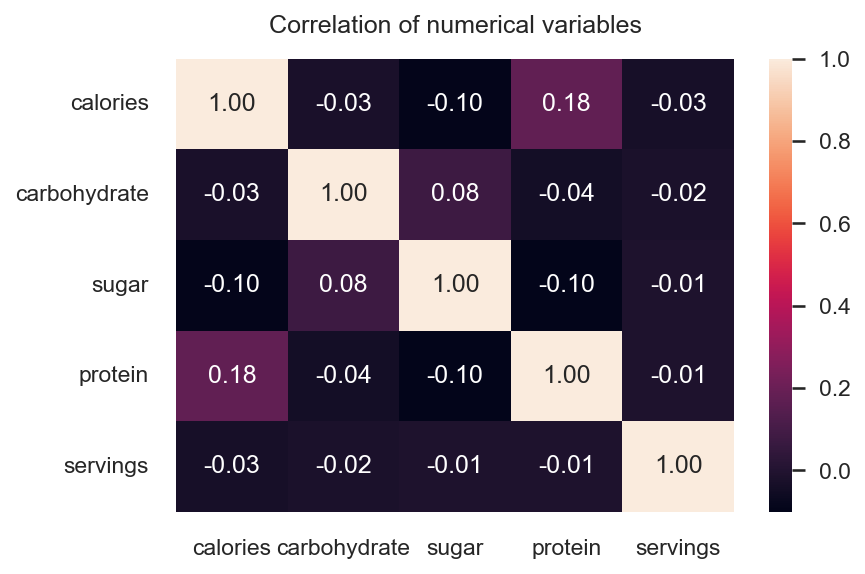

In [39]:
# Plot a heatmap of the correlation between numeric variables.
sns.heatmap(tb_df.corr(numeric_only=True,
                       method='pearson'),
            annot=True,
            fmt='.2f',            
           )
plt.title("Correlation of numerical variables",
          y=1.03)
plt.show()

The correlation coefficients among the numerical variables suggest the absence of strong linear relationships between them. Most of these coefficients cluster around 0, which may indicate either a lack of correlation or the presence of non-linear relationships that the Pearson correlation method cannot accurately capture. Notably, the weakest correlations, at -0.10, are observed between `sugar` and `calories`, as well as `sugar` and `protein`. Conversely, the highest correlation coefficient, at 0.18, exists between `calories` and `protein`.

However, it's important to note that these correlation coefficients may not accurately reflect the true relationships between the numerical variables due to the dataset's failure to meet the assumption of normally-distributed data. As mentioned earlier, data normalization will be a crucial step during the preprocessing phase of developing the machine learning model.

With these insights, I conclude my exploratory data analysis, and I will now proceed with the development of the machine learning model.

## ML Model Development 🦾

The project's objective, as set by the Tasty Bytes' product team, demands the development of a supervised ML model for binary classification, specifically designed to distinguish between popular and unpopular cooking recipes.

The ML model should be able to correctly classify popular recipes 80% of the time. Additionally, the ML model should actively work to minimize the chance of showing unpopular recipes on the company's homepage.

In the context of this classification prediction model, various input features will be leveraged to predict a target variable of interest.

Initially, I will create a new feature called `recipe_popularity` based on the information within the `high_traffic` column. Since popular recipes generate high web traffic, I will assign a label of `1` to `High` web traffic to indicate popular recipes and `0` to `Low` to indicate unpopular ones. Subsequently, the `high_traffic` column will be removed to avoid redundancy in providing duplicate information to the machine learning model, as its data will be encoded within the `recipe_popularity` column.

The `recipe_popularity` column contains the labels for the binary classification and therefore constitutes the target variable for this ML project. All other variables in the dataset will be employed as input features.

In [40]:
# Create a new feature recipe_popularity based on high_traffic.
tb_df['recipe_popularity'] = tb_df['high_traffic'].apply(
    lambda cat: 1 if cat == 'High' else 0
)

# Check the correct encoding of the recipe_popularity.
display(tb_df[['high_traffic', 'recipe_popularity']].head())
tb_df.value_counts(subset=['high_traffic', 'recipe_popularity']).to_frame()

,high_traffic,recipe_popularity
recipe,,
1,High,1
2,High,1
3,Low,0
4,High,1
5,Low,0


,,count
high_traffic,recipe_popularity,
High,1,574
Low,0,373


In [41]:
# Drop high_traffic column and create DataFrame for ML model: tb_ml.
tb_ml = tb_df.drop('high_traffic', axis=1)
tb_ml.head()

,calories,carbohydrate,sugar,protein,category,servings,recipe_popularity
recipe,,,,,,,
1,399.26,19.56,5.23,29.82,Pork,6,1
2,35.48,38.56,0.66,0.92,Potato,4,1
3,914.28,42.68,3.09,2.88,Breakfast,1,0
4,97.03,30.56,38.63,0.02,Beverages,4,1
5,27.05,1.85,0.80,0.53,Beverages,4,0


For the subsequent phase, I will employ one-hot encoding to convert the `category` column into numeric indicator variable. 

In [42]:
# Encode categorical data to numerical for the ML model.
tb_ml = pd.get_dummies(tb_ml, 
                       drop_first=True,
                       dtype='int')
tb_ml.head()

,calories,carbohydrate,sugar,protein,servings,recipe_popularity,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
recipe,,,,,,,,,,,,,,,
1,399.26,19.56,5.23,29.82,6,1,0,0,0,0,0,0,1,0,0
2,35.48,38.56,0.66,0.92,4,1,0,0,0,0,0,0,0,1,0
3,914.28,42.68,3.09,2.88,1,0,1,0,0,0,0,0,0,0,0
4,97.03,30.56,38.63,0.02,4,1,0,0,0,0,0,0,0,0,0
5,27.05,1.85,0.80,0.53,4,0,0,0,0,0,0,0,0,0,0


The DataFrame `tb_ml` is already in compliance with the prerequisites for supervised machine learning models, as it exclusively comprises numerical data without any missing values. 

Subsequently, I will generate a Series named `X` to hold the input features and a Series labeled `y` for the target variable, which contains the classification labels. The input features encompass all available columns except for `recipe_popularity`, which serves as the target variable.

In [43]:
# Create a DataFrame X containing the input features
# and a Series y with labels for the target variable.
X = tb_ml.drop('recipe_popularity',
               axis=1).values
y = tb_ml['recipe_popularity'].values

# Check the shape of X and y.
X.shape, y.shape

((947, 14), (947,))

In order to ensure the ML model's ability to generalize and make accurate predictions on unseen data, I will split the dataset into training (80%) and test (20%) sets.

In [44]:
# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=15)

As revealed during the exploratory data analysis, the majority of numerical variables exhibit non-normal distributions, significant variance, and varying scales. Consequently, to enhance the performance of many machine learning algorithms, it is imperative to preprocess and standardize the training data.

In [45]:
# Standardize the data for ML model training.
# Instantiate the scaler.
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

# Check the results of the standardization.
print(np.mean(X_train), np.std(X_train))
print(np.mean(X_train_scaled), np.std(X_train_scaled))

35.31107992073976 158.9317851280451
8.037017404155691e-17 1.0000000000000002


### Baseline ML Model 🛠

To create a baseline ML model for comparison with other more complex classifiers, I will initially implement the DummyClassifier.

In [46]:
# Create a baseline ML model with a DummyClassifier.
baseline_ml = DummyClassifier(strategy='stratified',
                              random_state=15)
baseline_ml.fit(X_train_scaled, y_train)
y_pred_bs_ml = baseline_ml.predict(X_test)

# Calculate accuracy.
bs_ml_accuracy = round(baseline_ml.score(X_test_scaled, y_test) * 100, 2)
print(bs_ml_accuracy)

# Calculate precision.
bs_ml_precision = round(metrics.precision_score(y_test, y_pred_bs_ml) * 100, 2)
print(bs_ml_precision)

52.63
60.33


The baseline ML model produced an accuracy rate of 52.63% and a precision score of 60.33%. This performance is notably subpar as it essentially mirrors the dataset's existing results, where over 60% of the recipes are classified as popular.

### Comparison ML Model 🔍

As no ML algorithm performs well on all data, I will try a variety of algorithm families to find the one that performs optimally on this particular  dataset. These algorithms include linear models, decision trees, and various ensemble methods.

The chosen classifiers for evaluation are as follows:

1. K-Nearest Neighbors
2. Gaussian Naive Bayes
3. Logistic Regression
4. Decision Tree
5. Bagging Classifier
6. Random Forest
7. AdaBoost
8. Gradient Boosting

I will execute all these classifiers in a `for` loop using k-fold cross validation.  For this cross-validation, I will need to utilize the complete set of input features `X`, which will undergo normalization, and the entire Series `y` containing the target variable.

The performance of these classifiers will be will be based on achieving an optimal Receiver Operating Characteristic Area Under the Curve (ROC AUC) score, while also aiming for a narrower standard deviation.

The ROC AUC score is a valuable metric for evaluating binary classification machine learning models, because of its robustness and ability to discriminate between classes. ROC AUC score is also very useful for direct model comparison.

In [47]:
# Standardize the input features.
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)

# Test various classifier algorithms.
for model in [KNeighborsClassifier,
              GaussianNB,
              LogisticRegression,
              DecisionTreeClassifier,
              BaggingClassifier,
              RandomForestClassifier,
              AdaBoostClassifier,
              GradientBoostingClassifier]:
    classifier = model()
    kfold = KFold(n_splits=10, 
                  random_state=15,
                  shuffle=True
                 )
    cv_score = cross_val_score(classifier, X_scaled, y,
                               scoring='roc_auc',
                               cv=kfold)
    print(f"{model.__name__:27} AUC: {cv_score.mean():.3f} "
          f"STD: {cv_score.std():.2f}")

KNeighborsClassifier        AUC: 0.764 STD: 0.04
GaussianNB                  AUC: 0.778 STD: 0.04
LogisticRegression          AUC: 0.825 STD: 0.03
DecisionTreeClassifier      AUC: 0.634 STD: 0.05
BaggingClassifier           AUC: 0.750 STD: 0.03
RandomForestClassifier      AUC: 0.786 STD: 0.04
AdaBoostClassifier          AUC: 0.789 STD: 0.05
GradientBoostingClassifier  AUC: 0.785 STD: 0.03


The ML classifier that demonstrates the most favorable performance on this dataset seems to be Logistic Regression. Consequently, I will employ Logistic Regression to train my benchmark machine learning model for comparison.

In [48]:
# Develop a comparison ML model with a LogistidRegression classifier.
# Instantiate the classifier.
lg = LogisticRegression(random_state=15)

# Fit the ML model to the training data.
lg.fit(X_train_scaled, y_train)

# Predict labels on the test set.
y_pred = lg.predict(X_test_scaled)

# Calculate ML model performance metrics.
lg_accuracy = round(lg.score(X_test_scaled, y_test) * 100, 2)
lg_precision = round(metrics.precision_score(y_test, y_pred) * 100, 2)
print(f"LogisticRegression ML model accuracy: {lg_accuracy}")
print(f"LogisticRegression ML model precision: {lg_precision}")

LogisticRegression ML model accuracy: 75.26
LogisticRegression ML model precision: 80.36


### ML Model Optimization 🛠

Each input feature conveys distinct signals to the ML algorithm, and it's crucial to assess their respective contributions and significance.

To visualize the feature importance of the comparison ML model, I will utilize the `FeatureImportances` class from the `Yellowbrick` package.

/home/daniel/.local/lib/python3.10/site-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


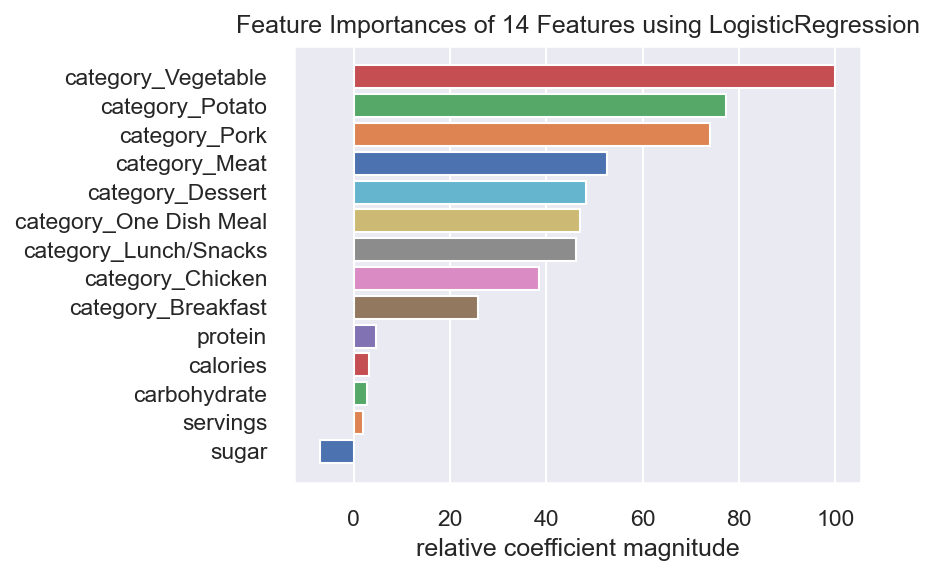

/tmp/ipykernel_31078/3484513358.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [49]:
# Visualize feature importance.
labels = tb_ml.drop('recipe_popularity', axis=1).columns

fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(lg, labels=labels)
fi_viz.fit(X_train_scaled, y_train)
fi_viz.poof()
fig.show()

The depicted plot above reveals that the one-hot encoded `category` variable holds the highest level of feature importance in the ML model. Conversely, the nutritional information employed as input features appears to offer comparatively less valuable signals to the model.

To enhance the model's performance, I will refine the selection of input features and construct the Logistic Regression model exclusively utilizing the `category` variable. This feature does not necessitate additional normalization.

In [50]:
# New model with category only.
X2 = tb_ml.drop(['recipe_popularity', 'calories', 'carbohydrate', 'sugar', \
                'protein', 'servings'], axis=1).values
y2 = tb_ml['recipe_popularity'].values

# Check the shape of X2 and y2.
X2.shape, y2.shape

((947, 9), (947,))

In [51]:
# Split data into training and test sets.
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=15)

# Instantiate the classifier.
log_reg2 = LogisticRegression(random_state=15)
log_reg2.fit(X_train2, y_train2)
y_pred2 = log_reg2.predict(X_test2)

# Calculate performance metrics.
accurary2 = round(log_reg2.score(X_test2, y_test2) * 100, 2)
print(accurary2)
precision2 = round(metrics.precision_score(y_test2, y_pred2) * 100, 2)
print(precision2)

75.79
81.08


Excluding the nutritional information from the input features seems to result in a modest enhancement of the ML model's performance. Both its accuracy and precision metrics indicate an improvement of slightly over half a percent.

ML models come equipped with hyperparameters that control their performance and behavior. To achieve the most favorable model performance, these hyperparameters can be refined by experimenting with various values to identify the optimal combination.

To optimize the comparison ML model, I will employ an exhaustive search method over predefined hyperparameters using GridSearchCV.

In [52]:
# Perform exhaustive search over specified parameter values for the estimator.
lg_hp = LogisticRegression(random_state=15)

# Define dictionary with hyperparameters to optimize.
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty': ['l2'],
    'random_state': [15]
}

lg_cv = GridSearchCV(lg_hp, param_grid, cv=5, n_jobs=-1) \
            .fit(X_train2, y_train2)

print(lg_cv.best_params_)

{'C': 1, 'penalty': 'l2', 'random_state': 15, 'solver': 'liblinear'}


The hyperparameter optimization via grid search yielded a dictionary containing the best values for the assessed hyperparameters. These optimal values will be incorporated into the ML model to assess its performance.

In [53]:
# Build a new ML model with the optimized hyperparamerers.
lg_opt = LogisticRegression(
    **{'C': 1, 
       'penalty': 'l2', 
       'random_state': 15, 
       'solver': 'liblinear'}
)

lg_opt.fit(X_train2, y_train2)

y_pred_opt = lg_opt.predict(X_test2)

# Calculate ML model performance metrics.
lg_opt_accuracy = round(lg_opt.score(X_test2, y_test2) * 100, 2)
lg_opt_precision = round(metrics.precision_score(y_test2, y_pred_opt) * 100, 2)
print(f"LogisticRegression ML model accuracy: {lg_opt_accuracy}")
print(f"LogisticRegression ML model precision: {lg_opt_precision}")

LogisticRegression ML model accuracy: 75.79
LogisticRegression ML model precision: 81.08


The optimized hyperparameters produced similar performance metrics as those used in developing the initial ML model.

### ML Model Evaluation ⚖️

Accuracy is a commonly-used evaluation metric to measure the average overall prediction performance of supervised classification ML models. However, it may not be reliable for models dealing with class imbalance issues.

The Tasty Bytes' product team has explicitly outlined a specific requirement for the ML model: it should correctly predict high-traffic recipes 80% of the time while simultaneously minimizing the display of unpopular recipes. This objective is better assessed using the **precision** metric, also known as the _positive predictive value_. Precision is calculated as the number of true positives divided by the sum of all positive predictions. A higher precision signifies that the ML model is less likely to showcase recipes on the homepage that were erroneously classified as popular.

To evaluate the performance of the ML model, I computed both accuracy and precision metrics, and the results are summarized in the `perf_metrics_df` DataFrame.

The ML model that excels in terms of these metrics is the LogisticRegression classifier, employing nine input features. This particular ML model achieves a precision score of approximately 81.08%.

In [54]:
# Create a DataFrame with the performance metrics of the ML models.
data = {'ML model': ['DummyClassifier', 
                     'LogisticRegression (14 features)', 
                     'LogisticRegression (9 features)'],
        'Accuracy' : [bs_ml_accuracy, lg_accuracy, lg_opt_accuracy],
        'Precision' : [bs_ml_precision, lg_precision, lg_opt_precision]}

perf_metrics_df = pd.DataFrame(data)
perf_metrics_df

,ML model,Accuracy,Precision
0,DummyClassifier,52.63,60.33
1,LogisticRegression (14 features),75.26,80.36
2,LogisticRegression (9 features),75.79,81.08


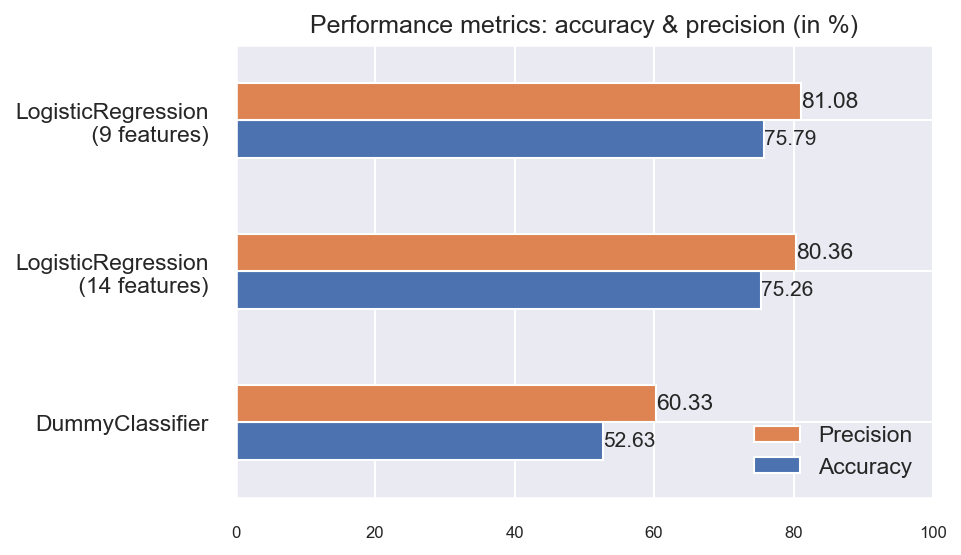

In [55]:
# Visualize and compare performance statistics of ML models.
ax = perf_metrics_df.plot.barh(label=["One", 2, 3],
                               tick_label=5,)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=11)
plt.xticks(range(0, 120, 20),
           fontsize=8)
plt.yticks([0, 1, 2], 
           ["DummyClassifier", 
            "LogisticRegression\n (14 features)", 
            "LogisticRegression\n (9 features)"])
#ax.yticks = perf_metrics_df['ML model']
plt.title("Performance metrics: accuracy & precision (in %)")
plt.legend(reverse=True)
plt.show()

## Business Metric Definition 📐

Tasty Bytes aims to enhance the quality of popular recipes featured on the homepage, recognizing their significant impact on increasing website traffic. According to the project's objectives, the chosen business metric to monitor aligns with the business goal, which is to increase web traffic by up to 40% through popular recipes. Therefore, the primary business metric to track is the volume of web traffic.

Currently, approximately 60% of the recipes contribute to high web traffic. By successfully employing an ML model that can identify popular recipes with a precision rate exceeding 80%, it is anticipated that web traffic will also experience a corresponding increase.

The initial web traffic increase by up to 40%, given 60% of popular recipes, can be calculated as:

$$ (60.61 * 40\%) + (39.39 * 0\%) = 24.24\% $$ 

If the ML model succeeds in elevating recipe popularity to 81.08%, the new web traffic projection can be calculated as:

$$ (81.08 * 40\%) + (18.92 * 0\%) = 32.43\% $$

Consequently, Tasty Bytes can expect to achieve a **_new web traffic increase of approximately 8.19%_** due to improved discovery of popular recipes.

## Summary and Recommendations 💡

Tasty Bytes faces a critical need to enhance its recipe discovery methods, as revealed by insights from the exploratory data analysis. Historically, recipe selection has relied heavily on subjective intuition from product managers. However, this analysis uncovered a concerning pattern where the majority of featured recipes belonged to categories that generated the lowest web traffic. Of particular concern is a category ranked fourth by popularity, yet simultaneously contributing to the worst web traffic. A deeper investigation into the distinguishing characteristics of this category is imperative.

Interestingly, these findings suggest that nutritional values play a minor role in driving recipe popularity. Instead, user interest seems to center around ingredients rather than the nutritional aspects of a meal.

Based on this analysis, I would strongly recommend the following actions for Tasty Bytes:

* _Enhanced Data Management:_   
    Invest significantly in improving data collection and management practices. Address the identified issues in the dataset, including missing data, mislabeled data, and incorrect data types.

* _Feature Investigation:_   
    Conduct a comprehensive investigation into the defining features of recipe popularity on the website. Consider implementing customer reviews and a rating system for recipes, as well as tracking recipe views as popularity metrics.

* _Expanded Popularity Metrics:_   
    Assess recipe popularity not only in terms of web traffic volume but also how it impacts customer engagement and services subscriptions. Utilize metrics such as conversion rate and click-through rate to gauge this impact.

* _User Engagement Metrics:_   
    Leverage user engagement metrics, including page views, session duration, and bounce rate, to gain additional insights into measuring recipe popularity and user behavior.

* _A/B Testing:_   
    Implement A/B testing to evaluate the effectiveness of the ML model's recommendations compared to a baseline (e.g., random recommendations). This will quantify the model's influence on user engagement and popularity.

* _Continuous Optimization:_   
    Embrace data science and ML algorithms to gather qualitative data continuously. Use this data to test, refine, and optimize the ML model consistently. Improving model performance will subsequently lead to better business results.
  
By following these recommendations and maintaining a data-driven approach, Tasty Bytes can not only enhance its recipe discovery methods but also improve overall website performance, user engagement, and, ultimately, business success.